Programming Language: R version 3.6.1 (2019-07-05) in Jupyter Notebook

## Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development, Comparison and Variable Identification](#sec_3)
* [Conclusion](#sec_6)
* [References](#sec_7)

In [1]:
# Libraries
library('psych')
library('ggcorrplot')
library('gridExtra')
library('e1071')
library('GGally')
library('caret')
library('mltools')
library('data.table')
library('car')
library('leaps')

Warning message:
"package 'psych' was built under R version 3.6.3"Warning message:
"package 'ggcorrplot' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

Warning message:
"package 'gridExtra' was built under R version 3.6.3"Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'GGally' was built under R version 3.6.3"Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.3"Warning message:
"package 'mltools' was built under R version 3.6.3"
Attaching package: 'mltools'

The following object is masked from 'package:e1071':

    skewness

Warning message:
"package 'data.table' w

## 1. Introduction <a class="anchor" id="sec_1"></a>

The dataset that we are going to use was originally collected from the northeast region of Portugal between January 2000 and December 2003. It contains geographical information such as fire weather indices and corresponding weather conditions. The aim is to build statistical models to predict the burned area of the bushfires. The questions posed to us that

* can we accurately predict the burned area of the bushfire given the collected data?
* can we explain our prediction and findings related to it.

The dataset contains 517 instances and 13 columns. The 12 columns corresponding to the attributes (e.g., spatial coordinates, month,day, four indices, and other meteorological data) and the last column containing the burned area, i.e., the variable that we will predict. Below are the specifications of the dataset that we are supposed to use:

Attribute information from forestfires.NAMES file:
   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84

In [2]:
# Loading the file 
forestFires <- read.csv('forestfires.csv', header = TRUE)

In [3]:
# Displaying first few rows of the dataframe 
head(forestFires)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


## 2. Data Exploration<a class="anchor" id="sec_2"></a>

In [4]:
# Checking the structure of the data 
str(forestFires)

'data.frame':	517 obs. of  13 variables:
 $ X    : int  7 7 7 8 8 8 8 8 8 7 ...
 $ Y    : int  5 4 4 6 6 6 6 6 6 5 ...
 $ month: Factor w/ 12 levels "apr","aug","dec",..: 8 11 11 8 8 2 2 2 12 12 ...
 $ day  : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC  : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC   : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI  : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH   : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area : num  0 0 0 0 0 0 0 0 0 0 ...


The structure of forest fires dataframe implies that except for the month and day variable which are factor datatype, all other variables are of integer datatype. I'll convert month and day into dummy variables with 0s and 1s.

In [5]:
# Checking the summary of the dataset
summary(forestFires)

       X               Y           month      day          FFMC      
 Min.   :1.000   Min.   :2.0   aug    :184   fri:85   Min.   :18.70  
 1st Qu.:3.000   1st Qu.:4.0   sep    :172   mon:74   1st Qu.:90.20  
 Median :4.000   Median :4.0   mar    : 54   sat:84   Median :91.60  
 Mean   :4.669   Mean   :4.3   jul    : 32   sun:95   Mean   :90.64  
 3rd Qu.:7.000   3rd Qu.:5.0   feb    : 20   thu:61   3rd Qu.:92.90  
 Max.   :9.000   Max.   :9.0   jun    : 17   tue:64   Max.   :96.20  
                               (Other): 38   wed:54                  
      DMC              DC             ISI              temp      
 Min.   :  1.1   Min.   :  7.9   Min.   : 0.000   Min.   : 2.20  
 1st Qu.: 68.6   1st Qu.:437.7   1st Qu.: 6.500   1st Qu.:15.50  
 Median :108.3   Median :664.2   Median : 8.400   Median :19.30  
 Mean   :110.9   Mean   :547.9   Mean   : 9.022   Mean   :18.89  
 3rd Qu.:142.4   3rd Qu.:713.9   3rd Qu.:10.800   3rd Qu.:22.80  
 Max.   :291.3   Max.   :860.6   Max.   :56.

In [6]:
# Looking for details about the dataset 
round(describe(forestFires), 2)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X,1,517,4.67,2.31,4.00,4.67,2.97,1.0,9.00,8.00,0.04,-1.18,0.10
Y,2,517,4.30,1.23,4.00,4.31,1.48,2.0,9.00,7.00,0.41,1.38,0.05
month*,3,517,6.76,4.37,7.00,6.72,7.41,1.0,12.00,11.00,0.08,-1.72,0.19
day*,4,517,3.74,1.93,4.00,3.67,2.97,1.0,7.00,6.00,0.16,-1.11,0.08
FFMC,5,517,90.64,5.52,91.60,91.45,1.93,18.7,96.20,77.50,-6.54,66.14,0.24
DMC,6,517,110.87,64.05,108.30,106.52,51.74,1.1,291.30,290.20,0.54,0.18,2.82
DC,7,517,547.94,248.07,664.20,578.69,118.90,7.9,860.60,852.70,-1.09,-0.27,10.91
ISI,8,517,9.02,4.56,8.40,8.73,3.11,0.0,56.10,56.10,2.52,21.15,0.20
temp,9,517,18.89,5.81,19.30,19.09,5.34,2.2,33.30,31.10,-0.33,0.11,0.26
RH,10,517,44.29,16.32,42.00,42.71,14.83,15.0,100.00,85.00,0.86,0.41,0.72


From the summary in above two cells, we can see that all the variables are on a different scale with varied set of values. It is clear that the variables DMC, DC and area are on a very high scale as their range is on the higher end. Also, the variables FFMC, DC, ISI, rain and area are heavily skewed. As suggested in the report, I will transform area into log of area+1.

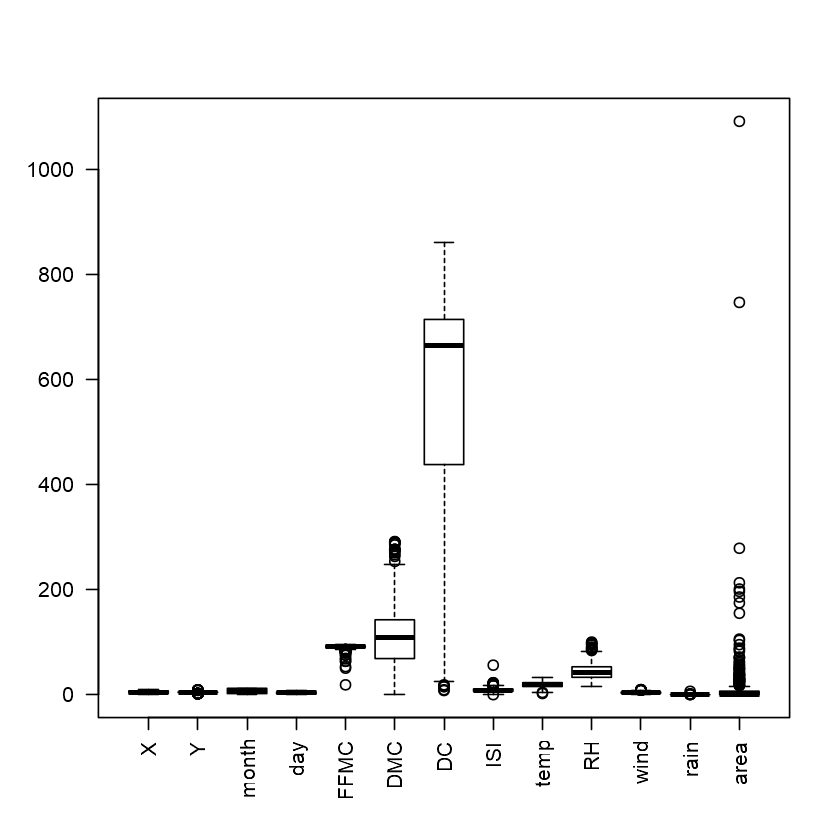

In [7]:
# Creating boxplots for all predictors except month and day
boxplot(forestFires, las=2, cex.axis = 1)

Since combined boxplot is difficult to interpret due to scale difference, let's plot them separately and check.

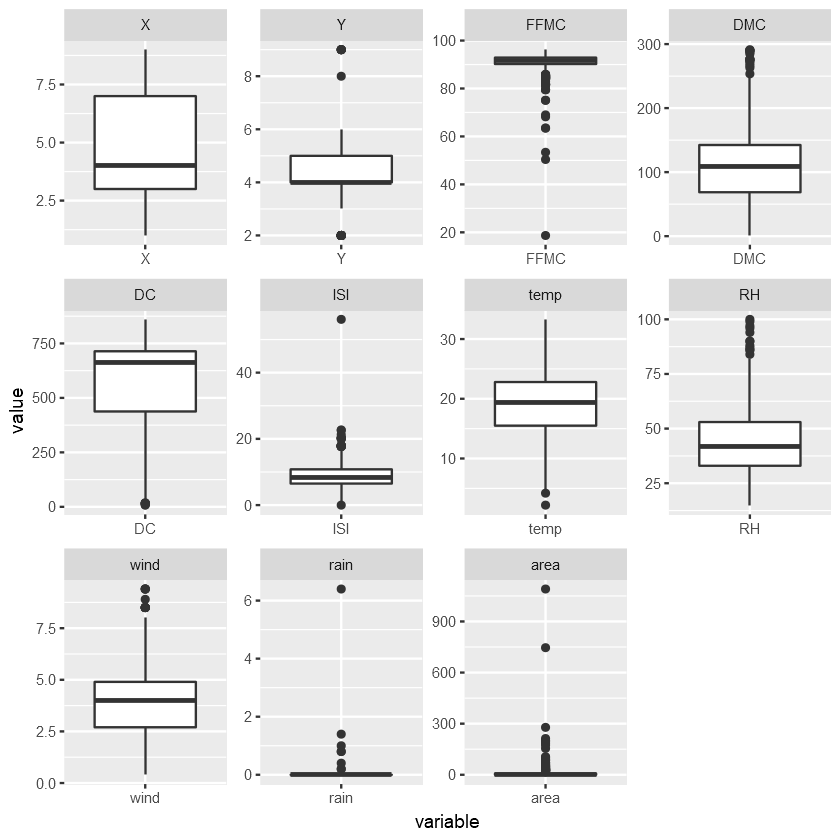

In [8]:
# Facet boxplots
forestFires.melt <- reshape2::melt(forestFires, id=c('month','day'))
ggplot(forestFires.melt,aes(x = variable,y = value)) + 
  facet_wrap(~variable, scales = "free") + 
  geom_boxplot()

In the above facet plot, we can see that there are many outliers for FFMC, DMC, RH, ISI, rain and area. Rain and area columns are heavily concentrated towards 0. It seems rain column is pretty much irrelevant for burned area prediction as it doesn't adds much to our knowledge. Let's check the distribution and correlation over raw dataset.

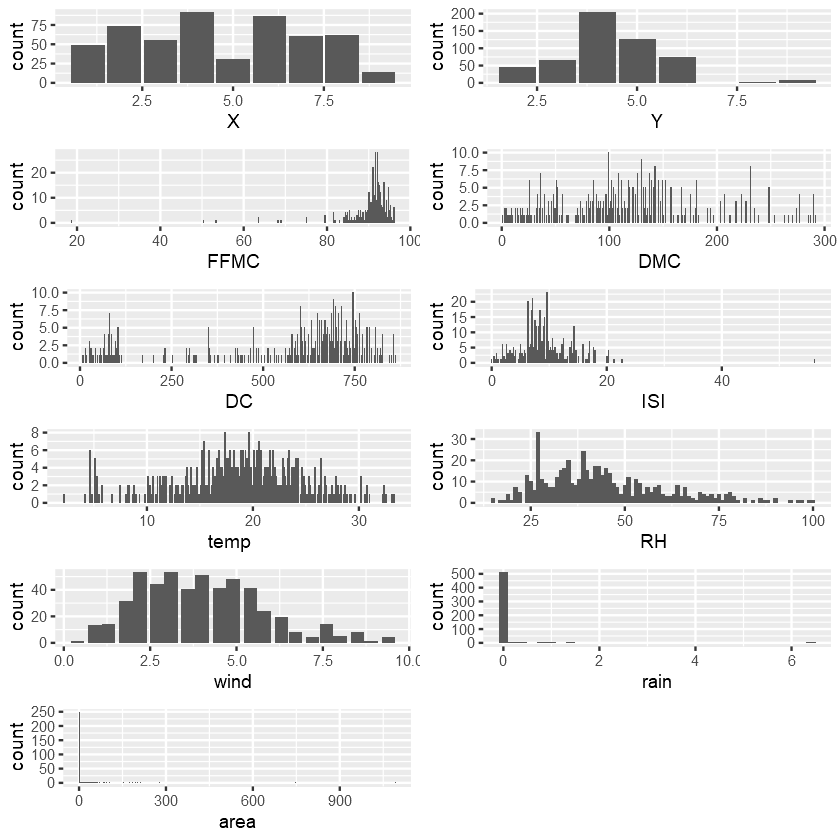

In [9]:
options(warn=-1)

# Plotting histograms for all variables except for month and day
q1<-ggplot(aes(x=X), data =  forestFires)+
    geom_histogram(stat = 'count')

q2<-ggplot(aes(x=Y), data =  forestFires)+
    geom_histogram(stat = 'count')

q5<-ggplot(aes(x=FFMC), data =  forestFires)+
    geom_histogram(stat = 'count')

q6<-ggplot(aes(x=DMC), data =  forestFires)+
    geom_histogram(stat = 'count')

q7<-ggplot(aes(x=DC), data =  forestFires)+
    geom_histogram(stat = 'count')

q8<-ggplot(aes(x=ISI), data =  forestFires)+
    geom_histogram(stat = 'count')

q9<-ggplot(aes(x=temp), data =  forestFires)+
    geom_histogram(stat = 'count')

q10<-ggplot(aes(x=RH), data =  forestFires)+
    geom_histogram(stat = 'count')

q11<-ggplot(aes(x=wind), data =  forestFires)+
    geom_histogram(stat = 'count')

q12<-ggplot(aes(x=rain), data =  forestFires)+
    geom_histogram(stat = 'count')

q13<-ggplot(aes(x=area), data =  forestFires)+
    geom_histogram(stat = 'count')

grid.arrange(q1,q2,q5,q6,q7,q8,q9,q10,q11,q12,q13,ncol=2)

From the above, histogram plots, we can see that distributions are not normal/gaussian or even close to it. Hence, I'll transform some of the predictors to reduce the skewness and bring their distribution close to normal form.

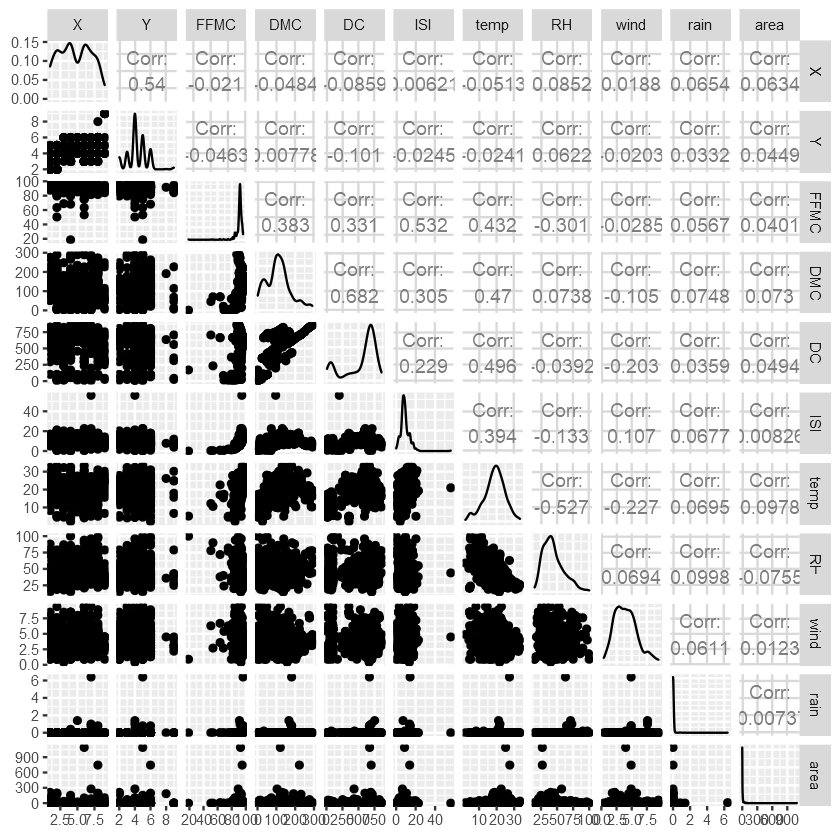

In [10]:
# Plotting the correlation between elements in the dataset except for month and day
ggpairs(forestFires[,c(-3,-4)])

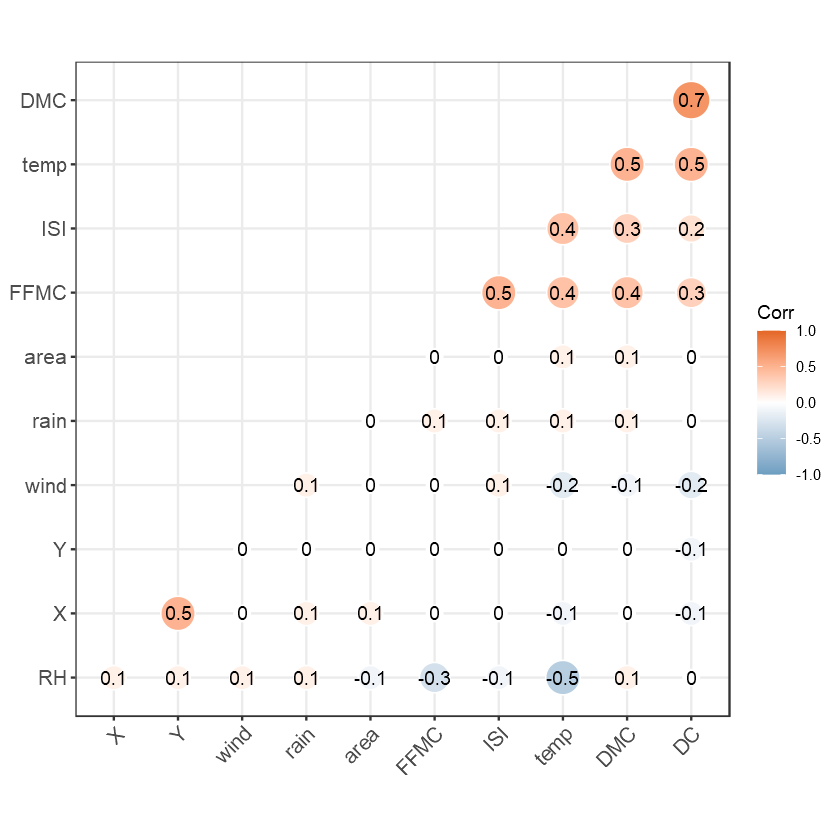

In [11]:
# Plotting another correlation graph
corr <- round(cor(forestFires[,c(-3,-4)]), 1)
ggcorrplot(corr, lab = TRUE,
           hc.order = TRUE, outline.col = "white",
           ggtheme = ggplot2::theme_bw(),
           colors = c("#6D9EC1", "white", "#E46726"),
           method = 'circle', type='lower')

Below are my findings from the above correlation plots:
* DMC and DC are strongly positively correlated.
* Temperature is moderately positively correlated with DMC, DC, FFMC and ISI.
* Temperature and Relative Humidity are moderately negatively correlated.
* X and Y are moderately positively correlated.
* Area has barely any correlation with the predictors.

As month and days are in the form of factors, I'll create encoded values for those columns as below.

In [12]:
# Transforming the month and day data
forestFires <- as.data.frame(one_hot(as.data.table(forestFires)))
head(forestFires)

X,Y,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,...,day_wed,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,0,0,0,0,0,0,0,1,...,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,0,0,0,0,0,0,0,0,...,0,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,0,0,0,0,0,0,0,0,...,0,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,0,0,0,0,0,0,0,1,...,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,0,0,0,0,0,0,0,1,...,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,0,1,0,0,0,0,0,0,...,0,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


Now let's create a new dataset with transformed values based on the skewness.

In [13]:
# Checking skewness for the features as it is
for(name in colnames(forestFires[,c(1,2,22,23,24,25,26,27,28,29)])){
    cat('skew for', name)
    cat(' : ')
    cat(skew(forestFires[,name]))
    cat('\n')
}

cat('\n')

# Checking skewness for the sqrt transformed features
for(name in colnames(forestFires[,c(1,2,22,23,24,25,26,27,28,29)])){
    cat('skew for sqrt', name)
    cat(' : ')
    cat(skew(sqrt(forestFires[,name])))
    cat('\n')
}

cat('\n')

# Checking skewness for the log transformed features
for(name in colnames(forestFires[,c(1,2,22,23,24,25,26,27,28,29)])){
    cat('skew for log', name)
    cat(' : ')
    cat(skew(log(forestFires[,name]+1)))
    cat('\n')
}

skew for X : 0.03603577
skew for Y : 0.4148779
skew for FFMC : -6.537499
skew for DMC : 0.5443249
skew for DC : -1.094068
skew for ISI : 2.521627
skew for temp : -0.329253
skew for RH : 0.8579033
skew for wind : 0.567692
skew for rain : 19.7015

skew for sqrt X : -0.345633
skew for sqrt Y : -0.1746773
skew for sqrt FFMC : -8.710686
skew for sqrt DMC : -0.377759
skew for sqrt DC : -1.401266
skew for sqrt ISI : 0.1471791
skew for sqrt temp : -0.9295162
skew for sqrt RH : 0.4474247
skew for sqrt wind : -0.00821058
skew for sqrt rain : 12.42046

skew for log X : -0.5662172
skew for log Y : -0.4892797
skew for log FFMC : -11.60773
skew for log DMC : -1.539253
skew for log DC : -1.85837
skew for log ISI : -0.9317864
skew for log temp : -1.543704
skew for log RH : 0.04914288
skew for log wind : -0.3195484
skew for log rain : 14.09089


Based on the skewness above, among all the transformations that would bring a predictor's distribution to close to gaussian form are as below:
* DMC - sqrt
* ISI - sqrt
* RH - log
* wind - sqrt

Now, I'll assign transformed values and check their distribution.

In [14]:
# Transforming values based on skewness to bring them close to normal form 
forestFires.transformed <- forestFires
forestFires.transformed$DMC <- sqrt(forestFires$DMC)
forestFires.transformed$ISI <- sqrt(forestFires$ISI)
forestFires.transformed$RH <- log(forestFires$RH)
forestFires.transformed$wind <- sqrt(forestFires$wind)

# Transforming area into log(area+1) as suggested in the report 
forestFires.transformed$area <- log(forestFires$area + 1)

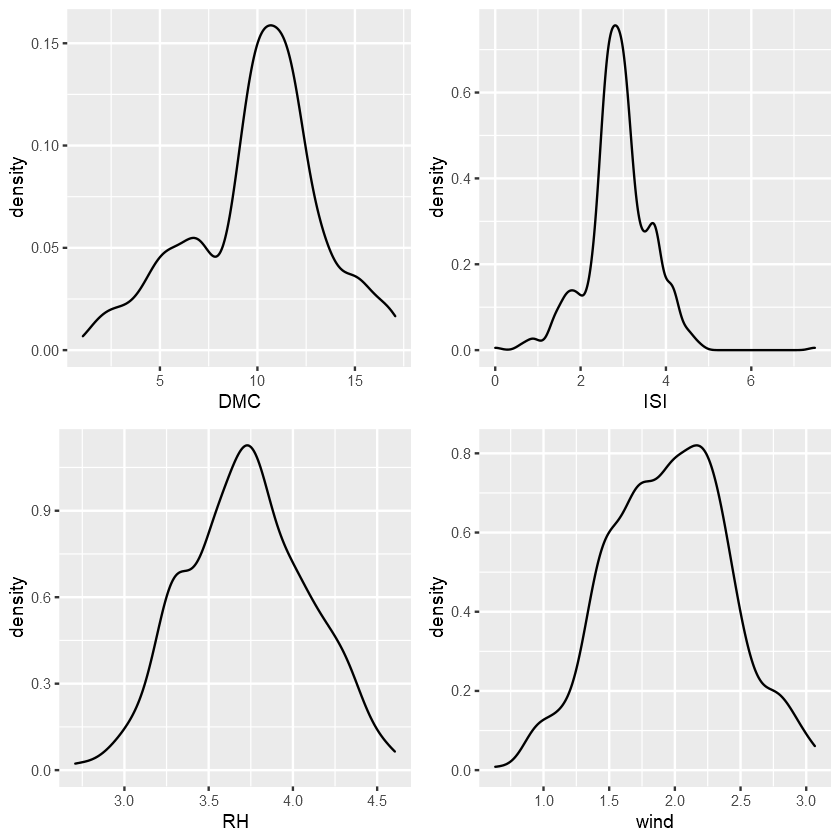

In [15]:
options(warn=-1)

# Plotting density graphs for the transformed variables
q1<-ggplot(aes(x=DMC), data =  forestFires.transformed) + geom_density()

q2<-ggplot(aes(x=ISI), data =  forestFires.transformed) + geom_density()

q3<-ggplot(aes(x=RH), data =  forestFires.transformed) + geom_density()

q4<-ggplot(aes(x=wind), data =  forestFires.transformed) + geom_density()

grid.arrange(q1,q2,q3,q4,ncol=2)

Now that we have two datasets ready, let's split them into training and testing sets.

In [16]:
# Shuffling the dataset before splitting
set.seed(12345)  # Set seed for reproducibility
index <- sample(1:nrow(forestFires), nrow(forestFires), FALSE)
forestFires <- forestFires[index,]
forestFires.transformed <- forestFires.transformed[index,]

# Split the datasets into training and testing
inTrain <- sample(1:nrow(forestFires), .80*nrow(forestFires), FALSE)

# For forestFires dataset
forestFires.train <- forestFires[inTrain,]
forestFires.test <- forestFires[-inTrain,]

# For forestFires.transformed dataset
forestFires.transformed.train <- forestFires.transformed[inTrain,]
forestFires.transformed.test <- forestFires.transformed[-inTrain,]

## 3. Model Development, Comparison and Variable Identification<a class="anchor" id="sec_3"></a>

Let's develop a model based on the raw dataset first and then build on it.

In [17]:
# Linear model fit for basic data
fit1 <- lm(area ~ ., data=forestFires.train)
summary(fit1)


Call:
lm(formula = area ~ ., data = forestFires.train)

Residuals:
    Min      1Q  Median      3Q     Max 
 -65.61  -21.22   -7.37    7.35 1030.82 

Coefficients: (2 not defined because of singularities)
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  79.91786  114.95457   0.695   0.4873  
X             2.81781    1.87174   1.505   0.1330  
Y            -0.57948    3.53828  -0.164   0.8700  
month_apr   -95.21634   52.99269  -1.797   0.0732 .
month_aug   -34.46912   13.36548  -2.579   0.0103 *
month_dec   -31.52487   41.27802  -0.764   0.4455  
month_feb   -89.91913   50.42524  -1.783   0.0753 .
month_jan   -74.42438   76.81206  -0.969   0.3332  
month_jul   -57.38670   26.22550  -2.188   0.0293 *
month_jun   -87.01611   36.95697  -2.355   0.0190 *
month_mar   -98.89536   46.06876  -2.147   0.0324 *
month_may   -83.21738   66.46176  -1.252   0.2113  
month_nov   -96.92138   84.41292  -1.148   0.2516  
month_oct    -2.65632   22.82520  -0.116   0.9074  
month_sep     

PS: Since the split is random and above code would generate different values altogether, I've run it multiple times and writing down my observations based on that (The set seed functionality isn't working properly).

From the above summary of the linear model fit, we see that the median of the residuals is no where close to 0. Also, DMC and DC are the predictors that have probabilities that are significant based on level 0.05. All other predictors except for few months are pretty much useless to predict the area when we use the basic dataset.The residual error is also high and the R squared value which gives information about the model accuracy is in negative. It implies that the residual error is much greater than the total of squared errors. Also the p-value of the model is 0.7 which is quite high. Ideally, we would want it to lie around 0.05-0.01. As it is established that this model is bad, let's try on with the transformed dataset. At this point, it is irrelevant to check the predictions with the testing dataset.

In [18]:
# Test MSE calculation for above model in terms of ha
mean((forestFires.test[,30] - predict(fit1,forestFires.test))**2)

[1] 584.2914

The above cell displays the MSE for this model in terms of ha. It implies that the prediction is off by those many hectares.

In [19]:
# Linear model fit for transformed data 
fit2 <- lm(area ~ ., data=forestFires.transformed.train)
summary(fit2)


Call:
lm(formula = area ~ ., data = forestFires.transformed.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8766 -1.0591 -0.4601  0.8514  5.1647 

Coefficients: (2 not defined because of singularities)
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.583840   2.636995   0.221  0.82490   
X            0.054411   0.037368   1.456  0.14618   
Y           -0.051095   0.070488  -0.725  0.46897   
month_apr   -0.867331   1.008211  -0.860  0.39018   
month_aug   -0.709610   0.271106  -2.617  0.00921 **
month_dec    1.270831   0.806273   1.576  0.11581   
month_feb   -0.750393   0.945401  -0.794  0.42784   
month_jan   -1.028991   1.493007  -0.689  0.49111   
month_jul   -0.911835   0.524543  -1.738  0.08295 . 
month_jun   -1.526427   0.738939  -2.066  0.03953 * 
month_mar   -1.518830   0.884990  -1.716  0.08693 . 
month_may   -0.408209   1.306631  -0.312  0.75490   
month_nov   -2.026358   1.647376  -1.230  0.21943   
month_oct    0.134573   0.472685   0.285

From the above summary of the linear model fit, compared to the previous fit, we see that the median of residuals is somewhat closer to zero and more number of parameters have become significant, we got better R squared rate - it is no more in negative - implying that the RSS is less than the TSS. Also, the p-value of the model is closer to 0.05. The F-statistic, which signifies if R squared value is significant or not, is comparitively higher. It seems that the transformations did help build model accuracy. However, it is still a bad model as it gives only 1.5% accuracy rate. Let's apply step function to this so that we would get final subset of predictors that would improve our model.

In [20]:
# Applying step on fit 2 
step(fit2)

Start:  AIC=314.87
area ~ X + Y + month_apr + month_aug + month_dec + month_feb + 
    month_jan + month_jul + month_jun + month_mar + month_may + 
    month_nov + month_oct + month_sep + day_fri + day_mon + day_sat + 
    day_sun + day_thu + day_tue + day_wed + FFMC + DMC + DC + 
    ISI + temp + RH + wind + rain


Step:  AIC=314.87
area ~ X + Y + month_apr + month_aug + month_dec + month_feb + 
    month_jan + month_jul + month_jun + month_mar + month_may + 
    month_nov + month_oct + month_sep + day_fri + day_mon + day_sat + 
    day_sun + day_thu + day_tue + FFMC + DMC + DC + ISI + temp + 
    RH + wind + rain


Step:  AIC=314.87
area ~ X + Y + month_apr + month_aug + month_dec + month_feb + 
    month_jan + month_jul + month_jun + month_mar + month_may + 
    month_nov + month_oct + day_fri + day_mon + day_sat + day_sun + 
    day_thu + day_tue + FFMC + DMC + DC + ISI + temp + RH + wind + 
    rain

            Df Sum of Sq    RSS    AIC
- rain       1    0.0136 772.99 312.87
- R


Call:
lm(formula = area ~ X + month_aug + month_dec + month_jul + month_jun + 
    month_mar + DMC + DC + temp, data = forestFires.transformed.train)

Coefficients:
(Intercept)            X    month_aug    month_dec    month_jul    month_jun  
   0.273513     0.043171    -0.536706     1.832266    -0.549387    -1.045278  
  month_mar          DMC           DC         temp  
  -0.726504     0.118886    -0.001575     0.034106  


The step function tries out various combinations of predictors to predict the target label such that the model remains simple as well as the accuracy is maintained. The selection is based on AIC parameter which is the measure of quality of a model compared with other models of subset of features from same model. By applying step to our model, we got a model with subset of features a below.

In [21]:
# Model obtained using step function
fit3 <- lm(formula = area ~ X + month_aug + month_dec + month_jul + month_jun + 
    month_mar + DMC + DC + temp, data = forestFires.transformed.train)

summary(fit3)


Call:
lm(formula = area ~ X + month_aug + month_dec + month_jul + month_jun + 
    month_mar + DMC + DC + temp, data = forestFires.transformed.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9144 -1.0712 -0.5169  0.8275  5.3609 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2735132  0.3603946   0.759  0.44834   
X            0.0431709  0.0303316   1.423  0.15542   
month_aug   -0.5367057  0.2019019  -2.658  0.00817 **
month_dec    1.8322662  0.5742137   3.191  0.00153 **
month_jul   -0.5493870  0.3546529  -1.549  0.12215   
month_jun   -1.0452777  0.4584098  -2.280  0.02312 * 
month_mar   -0.7265037  0.3467508  -2.095  0.03678 * 
DMC          0.1188862  0.0427407   2.782  0.00566 **
DC          -0.0015751  0.0006727  -2.342  0.01969 * 
temp         0.0341064  0.0161670   2.110  0.03551 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.4 on 403 degrees of freedom
Multiple R-squared:  0.

In the above model summary, we see that the median of residuals is close to 0, only important features that add to the improvement in accuracy as well as predcition of burned area remain and most of them are significant based on individual probability value. It can be noticed that month_aug, month_dec and DMC have most significance with level 0.01, followed by month_june, month_mar, DC and temp with significance level of 0.05. This step has cut down the number of predictors making the model simpler also maintaining better R squared value, F-statistic score and model p-value. Now let's check the fit based on few plots

In [22]:
# Test MSE calculation for above model in terms of log(area+1)
mean((predict(fit3,forestFires.transformed.test) - forestFires.transformed.test[,30])**2)

[1] 1.53222

In [23]:
# Test MSE calculation for above model in terms of ha
mean((exp(predict(fit3,forestFires.transformed.test))-1 - exp(forestFires.transformed.test[,30])-1)**2)

[1] 355.479

The above two cells show the test MSE for the above model in terms of log(area+1) as well as in terms of ha. The difference between this model and the previous model is clearly visible. The test MSE is very lower for this one.

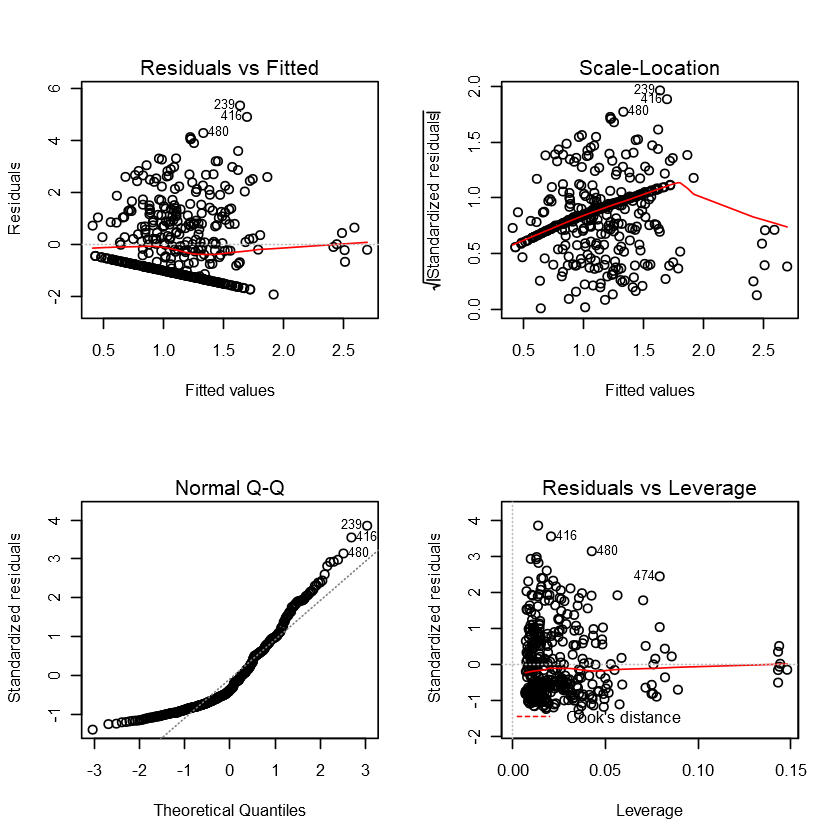

In [24]:
# Plotting graphs to understand the model performance 
par(mfcol=c(2,2))
plot(fit3)

Below are my findings from the above plot:
* For the first plot, residuals vs fitted, it is expected that the red line stays as close to zero as possible and the data points around shouldn't follow pattern and should be spread equally but that is not the case here.
* For next plot, scale-location, it is expected that the line should be horizontal but it is totaly bent. Also the data points are following a pattern.
* In normal q-q plot, we see that the points are properly distributed along the line. This implies that the distribution isn't the same and the residuals and quantiles are not correlatedstrongly.
* In residual vs leverage, we can identify the influential point based on the score of cook's distance but in this case, the dotted line for cook's distance itself is not shown. Hence, there are no outliers that are influential points.

Although the model has a very bad R squared score and MSE value over test data, I had plotted the above graphs to understand about the model.

In [25]:
# Updated model with the interaction terms based on intuition and trial and error
fit4 <- update(fit3, area ~ . +DMC:DC +temp:DMC)

summary(fit4)


Call:
lm(formula = area ~ X + month_aug + month_dec + month_jul + month_jun + 
    month_mar + DMC + DC + temp + DMC:DC + DMC:temp, data = forestFires.transformed.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8423 -1.0492 -0.4839  0.7974  5.2826 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  6.225e-01  6.745e-01   0.923  0.35664   
X            4.482e-02  3.027e-02   1.481  0.13941   
month_aug   -6.884e-01  2.240e-01  -3.072  0.00227 **
month_dec    1.323e+00  6.281e-01   2.107  0.03576 * 
month_jul   -7.727e-01  4.137e-01  -1.868  0.06249 . 
month_jun   -1.348e+00  5.552e-01  -2.428  0.01560 * 
month_mar   -8.388e-01  3.920e-01  -2.140  0.03299 * 
DMC          1.597e-01  1.121e-01   1.425  0.15499   
DC           3.967e-05  1.031e-03   0.038  0.96933   
temp        -4.463e-02  5.009e-02  -0.891  0.37350   
DMC:DC      -2.394e-04  1.323e-04  -1.810  0.07100 . 
DMC:temp     7.006e-03  4.381e-03   1.599  0.11061   
---
Signif. codes:

In [26]:
# Test MSE calculation for above model in terms of log(area+1)
mean((predict(fit4,forestFires.transformed.test) - forestFires.transformed.test[,30])**2)

[1] 1.557787

In [27]:
# Test MSE calculation for above model in terms of ha
mean((exp(predict(fit4,forestFires.transformed.test))-1 - exp(forestFires.transformed.test[,30])-1)**2)

[1] 354.7846

By adding interaction term, we can see that there is a significant increase in the R squared value, F-statistic and reduced p-value of the model and residual standard error. However, there's barely any difference in the test MSE. For this accuracy rate, it wouldn't matter even if interaction terms are added. Anyway, based on our fit4 model, let's see if there are any outliers and if there are any influential points.

In [28]:
# Checking for the outlier test 
outlierTest(fit4, cutoff=0.05, digits = 1)

No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
    rstudent unadjusted p-value Bonferroni p
239 3.878544         0.00012283     0.050728

The above outlier test shows that there are no residuals with p <0.05 and that data point 239 isn't a outlier

,StudRes,Hat,CookD
416,3.5136086,0.03072315,0.0317122178
474,2.6875840,0.08829705,0.0574047266
275,-0.1337224,0.14826826,0.0002600384
281,-0.1391492,0.14543814,0.0002752824
480,3.1632035,0.04314981,0.0367758081
239,3.8785445,0.01542826,0.0189791673


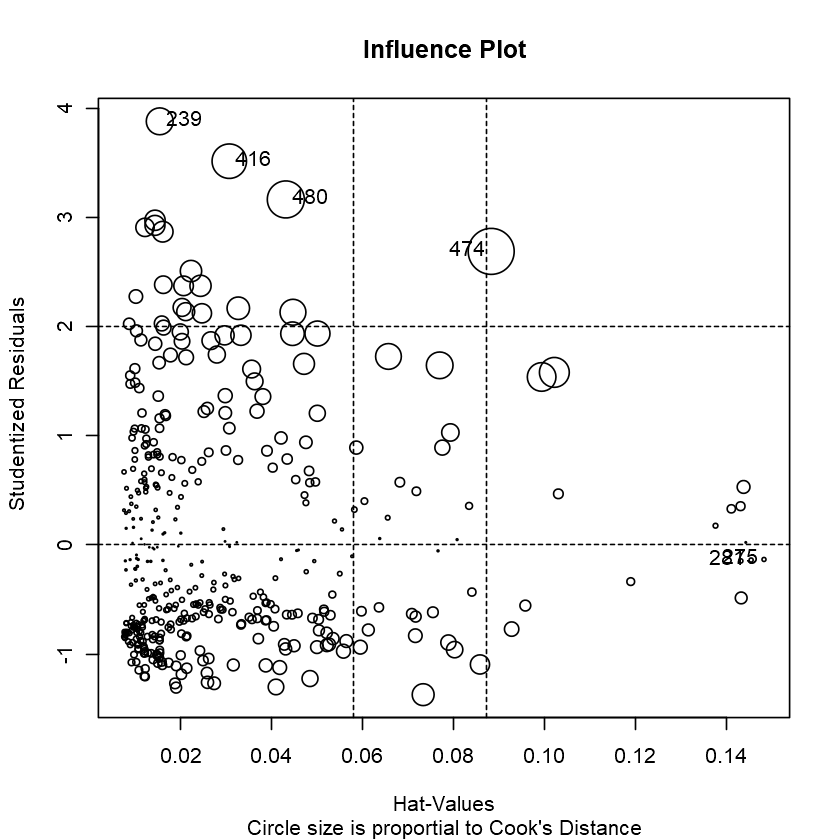

In [29]:
# Checking for influential point 
influencePlot(fit4, scale=5, id.method="noteworthy", main="Influence Plot", sub="Circle size is proportial to Cook's Distance" )

In the above cell, we can see a data frame with the hat values, Studentized residuals and Cook's distance. In the influence plot, the two dashed vertical lines as well as the horiontal lines are drawn at twice the average hat value. The two horizontal lines are drawn at 0 and 2 on the Studentized-residual scale.

In [30]:
# Comparing the models
anova(fit1, fit2, fit3, fit4)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
385,1942008.2685,NA,NA,NA,NA
385,772.9734,0,1.941235e+06,NA,NA
403,790.2817,-18,-1.730839e+01,0.0001906311,1.0000000
401,781.9839,2,8.297813e+00,0.0008225140,0.9991778


By using anova, we can compare the models from the same variation. As we can see from the above cell result, the RSS value has decreased as we tried to improve the models with transformations and interactions. Although the F score, p-value of the model and sum of squares are bad, considering the F-statistics and R sq value, we can consider the fit4 as better fit.


Now let's try selecting features which would pose best possible results using regsubsets. I'll apply both forward and backward steps and verify if I'm getting the best possible model as predicted earlier.

In [31]:
# Feature selection based on regubsets
regfit.full <- regsubsets(area ~ X + month_aug + month_dec + month_jul + month_jun + 
    month_mar + DMC + DC + temp + DMC:DC + DMC:temp, data = forestFires.transformed.train, nvmax = 10)
reg.summary <- summary(regfit.full)
reg.summary

Subset selection object
Call: regsubsets.formula(area ~ X + month_aug + month_dec + month_jul + 
    month_jun + month_mar + DMC + DC + temp + DMC:DC + DMC:temp, 
    data = forestFires.transformed.train, nvmax = 10)
11 Variables  (and intercept)
          Forced in Forced out
X             FALSE      FALSE
month_aug     FALSE      FALSE
month_dec     FALSE      FALSE
month_jul     FALSE      FALSE
month_jun     FALSE      FALSE
month_mar     FALSE      FALSE
DMC           FALSE      FALSE
DC            FALSE      FALSE
temp          FALSE      FALSE
DMC:DC        FALSE      FALSE
DMC:temp      FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          X   month_aug month_dec month_jul month_jun month_mar DMC DC  temp
1  ( 1 )  " " " "       "*"       " "       " "       " "       " " " " " " 
2  ( 1 )  " " " "       "*"       " "       " "       " "       " " " " " " 
3  ( 1 )  " " "*"       "*"       " "       " "       " "       " " " " " " 
4  ( 1 ) 

The above summary() function will output the best set of variables for each model size from 1 to 10. An asterisk indicates that a variable in the corresponding column is included in the model. For example, the best one-variable model only contains month_dec.

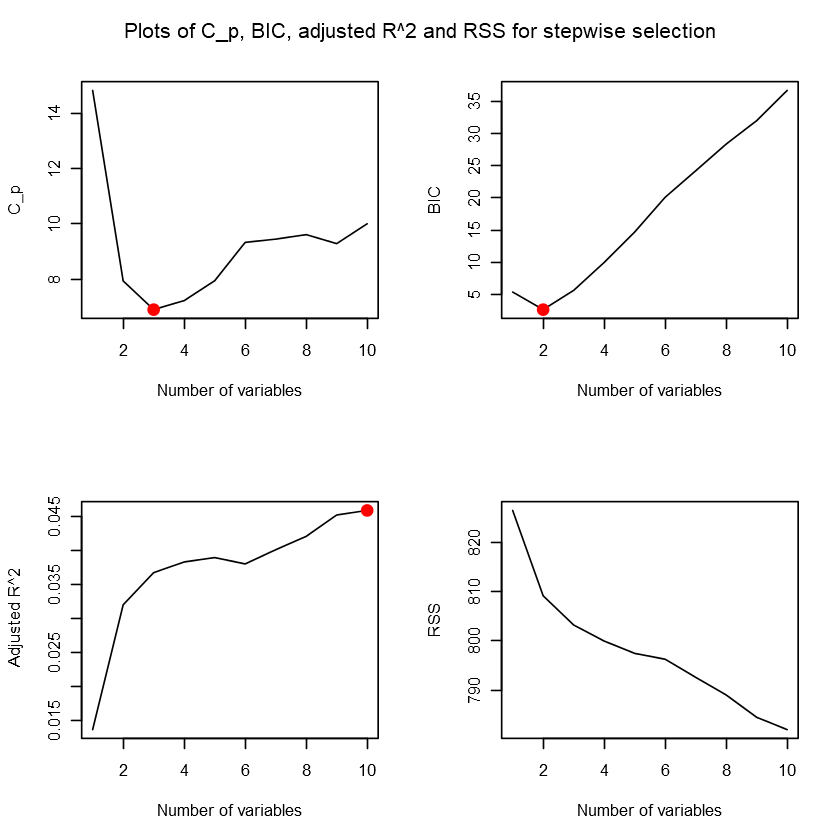

In [32]:
# Plotting the graph for stepwise
par(mfrow = c(2, 2))
plot(reg.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(reg.summary$cp), reg.summary$cp[which.min(reg.summary$cp)], col = "red", cex = 2, pch = 20)
plot(reg.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(reg.summary$bic), reg.summary$bic[which.min(reg.summary$bic)], col = "red", cex = 2, pch = 20)
plot(reg.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(reg.summary$adjr2), reg.summary$adjr2[which.max(reg.summary$adjr2)], col = "red", cex = 2, pch = 20)
plot(reg.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS for stepwise selection", side = 3, line = -2, outer = TRUE)

In [33]:
# Finding out the coefficients based on different parameters such as Cp, BIC and R sq
cat('Cp\n')
coef(regfit.full, which.min(reg.summary$cp))
cat('BIC\n')
coef(regfit.full, which.min(reg.summary$bic))
cat('R sq\n')
coef(regfit.full, which.max(reg.summary$adjr2))

Cp


(Intercept)    month_aug    month_dec     DMC:temp 
 0.648156899 -0.289406445  1.804839551  0.002850188

BIC


(Intercept)   month_dec    DMC:temp 
 0.68724767  1.78212988  0.00214046

R sq


(Intercept)             X     month_aug     month_dec     month_jul 
 0.6182510577  0.0447822038 -0.6887379370  1.3307571032 -0.7737851301 
    month_jun     month_mar           DMC          temp        DMC:DC 
-1.3498672381 -0.8429879324  0.1599258722 -0.0433882153 -0.0002360616 
     DMC:temp 
 0.0069054034

Below are my findings from the above plots:
* From the first plot, using Mallow's CP, we can determine that the best model is created using 3 parameters only.
* The corresponding coefficients are under section Cp in the above cell.
* From the second plot, using BIC, we can determine that the best model is created using 2 parameters only.
* The corresponding coefficients are under section BIC in the above cell.
* From the third plot, using adjusted R sq value, we can determine that the best model is created using all the parameters.
* The corresponding coefficients are under section R sq in the above cell.
* From the last plot, we can notice that RSS decreases as the number variable increases.

In [34]:
# Subset selection based on forward stepwise selection 
regfit.fwd <- regsubsets(area ~ X + month_aug + month_dec + month_jul + month_jun + 
    month_mar + DMC + DC + temp + DMC:DC + DMC:temp, data = forestFires.transformed.train, nvmax = 10, method = "forward")
reg.summary.fwd <- summary(regfit.fwd)
reg.summary.fwd 
reg.summary

Subset selection object
Call: regsubsets.formula(area ~ X + month_aug + month_dec + month_jul + 
    month_jun + month_mar + DMC + DC + temp + DMC:DC + DMC:temp, 
    data = forestFires.transformed.train, nvmax = 10, method = "forward")
11 Variables  (and intercept)
          Forced in Forced out
X             FALSE      FALSE
month_aug     FALSE      FALSE
month_dec     FALSE      FALSE
month_jul     FALSE      FALSE
month_jun     FALSE      FALSE
month_mar     FALSE      FALSE
DMC           FALSE      FALSE
DC            FALSE      FALSE
temp          FALSE      FALSE
DMC:DC        FALSE      FALSE
DMC:temp      FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: forward
          X   month_aug month_dec month_jul month_jun month_mar DMC DC  temp
1  ( 1 )  " " " "       "*"       " "       " "       " "       " " " " " " 
2  ( 1 )  " " " "       "*"       " "       " "       " "       " " " " " " 
3  ( 1 )  " " "*"       "*"       " "       " "       " "       " " "

Subset selection object
Call: regsubsets.formula(area ~ X + month_aug + month_dec + month_jul + 
    month_jun + month_mar + DMC + DC + temp + DMC:DC + DMC:temp, 
    data = forestFires.transformed.train, nvmax = 10)
11 Variables  (and intercept)
          Forced in Forced out
X             FALSE      FALSE
month_aug     FALSE      FALSE
month_dec     FALSE      FALSE
month_jul     FALSE      FALSE
month_jun     FALSE      FALSE
month_mar     FALSE      FALSE
DMC           FALSE      FALSE
DC            FALSE      FALSE
temp          FALSE      FALSE
DMC:DC        FALSE      FALSE
DMC:temp      FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          X   month_aug month_dec month_jul month_jun month_mar DMC DC  temp
1  ( 1 )  " " " "       "*"       " "       " "       " "       " " " " " " 
2  ( 1 )  " " " "       "*"       " "       " "       " "       " " " " " " 
3  ( 1 )  " " "*"       "*"       " "       " "       " "       " " " " " " 
4  ( 1 ) 

We see minor difference in terms of subset selections (for features>4) from the above two summaries.

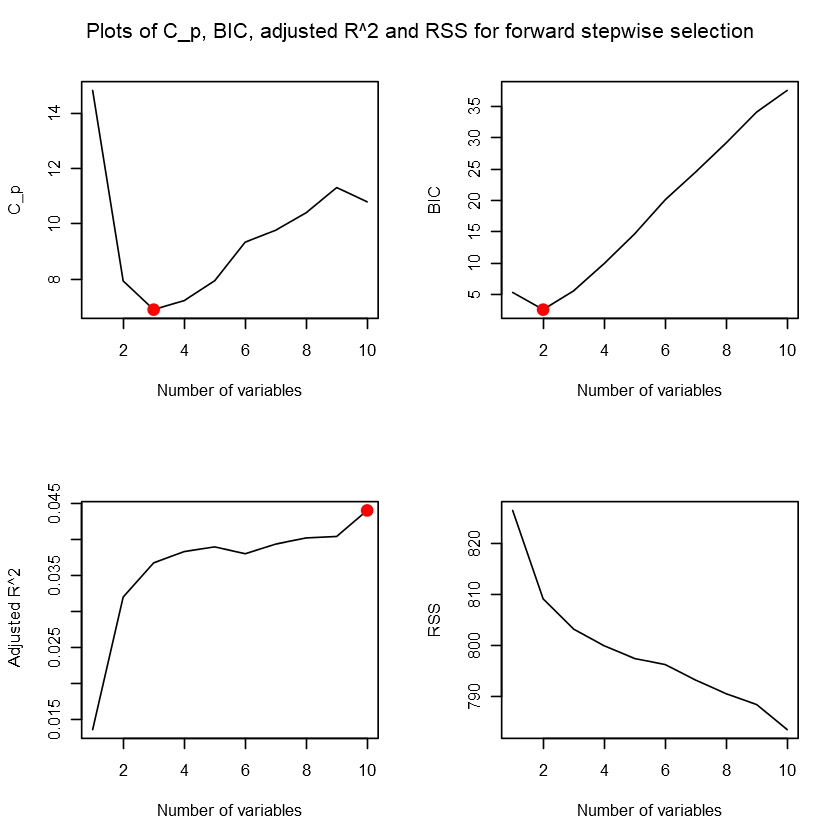

In [35]:
# Plotting the graph for forward stepwise selection
par(mfrow = c(2, 2))
plot(reg.summary.fwd$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(reg.summary.fwd$cp), reg.summary.fwd$cp[which.min(reg.summary.fwd$cp)], col = "red", cex = 2, pch = 20)
plot(reg.summary.fwd$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(reg.summary.fwd$bic), reg.summary.fwd$bic[which.min(reg.summary.fwd$bic)], col = "red", cex = 2, pch = 20)
plot(reg.summary.fwd$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(reg.summary.fwd$adjr2), reg.summary.fwd$adjr2[which.max(reg.summary.fwd$adjr2)], col = "red", cex = 2, pch = 20)
plot(reg.summary.fwd$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS for forward stepwise selection", side = 3, line = -2, outer = TRUE)

In [36]:
# Finding out the coefficients for 3 feature model 
coef(regfit.fwd, 3)

(Intercept)    month_aug    month_dec     DMC:temp 
 0.648156899 -0.289406445  1.804839551  0.002850188

Even after performing forward stepwise, we can see that the same subset was chosen which gives good results.

In [37]:
# Subset selection using backward stepwise function 
regfit.bwd <- regsubsets(area ~ X + month_aug + month_dec + month_jul + month_jun + 
    month_mar + DMC + DC + temp + DMC:DC + DMC:temp, data = forestFires.transformed.train, nvmax = 10, method = "backward")
reg.summary.bwd <- summary(regfit.bwd)
reg.summary.bwd

Subset selection object
Call: regsubsets.formula(area ~ X + month_aug + month_dec + month_jul + 
    month_jun + month_mar + DMC + DC + temp + DMC:DC + DMC:temp, 
    data = forestFires.transformed.train, nvmax = 10, method = "backward")
11 Variables  (and intercept)
          Forced in Forced out
X             FALSE      FALSE
month_aug     FALSE      FALSE
month_dec     FALSE      FALSE
month_jul     FALSE      FALSE
month_jun     FALSE      FALSE
month_mar     FALSE      FALSE
DMC           FALSE      FALSE
DC            FALSE      FALSE
temp          FALSE      FALSE
DMC:DC        FALSE      FALSE
DMC:temp      FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: backward
          X   month_aug month_dec month_jul month_jun month_mar DMC DC  temp
1  ( 1 )  " " " "       "*"       " "       " "       " "       " " " " " " 
2  ( 1 )  " " " "       "*"       " "       " "       " "       " " " " " " 
3  ( 1 )  " " "*"       "*"       " "       " "       " "       " "

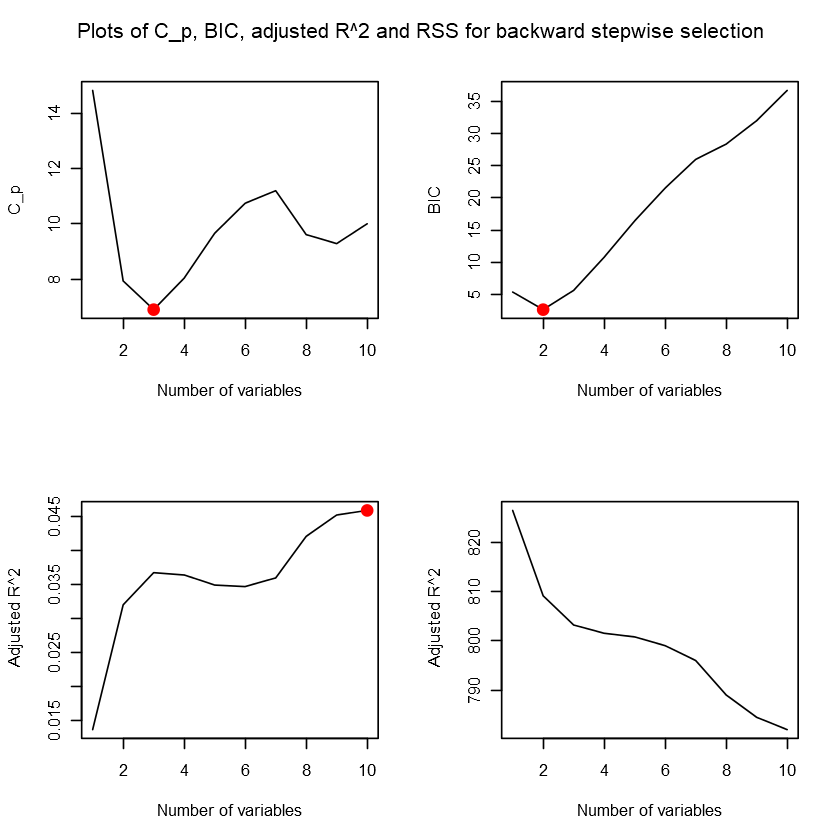

In [38]:
# Plotting the graph for backward stepwise selection 
par(mfrow = c(2, 2))
plot(reg.summary.bwd$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(reg.summary.bwd$cp), reg.summary.bwd$cp[which.min(reg.summary.bwd$cp)], col = "red", cex = 2, pch = 20)
plot(reg.summary.bwd$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(reg.summary.bwd$bic), reg.summary.bwd$bic[which.min(reg.summary.bwd$bic)], col = "red", cex = 2, pch = 20)
plot(reg.summary.bwd$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(reg.summary.bwd$adjr2), reg.summary.bwd$adjr2[which.max(reg.summary.bwd$adjr2)], col = "red", cex = 2, pch = 20)
plot(reg.summary.bwd$rss, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS for backward stepwise selection", side = 3, line = -2, outer = TRUE)

In [39]:
# Finding out the coefficients for 3 variables model 
coef(regfit.bwd, 3)

(Intercept)    month_aug    month_dec     DMC:temp 
 0.648156899 -0.289406445  1.804839551  0.002850188

Even after performing backward stepwise, we can see that the same subset was chosen which gives good results. Also, the graphs for both forward and backward step approach are similar.

Now that I've tried linear regression forms, I'll try KNN regression based on the raw dataset and my model fit3 without the interaction terms and check if this gives better results. In order to perform KNN, we need to scale the values as it considers the distance from each point, in this case - predictors. Using caret, function, I've performed KNN regression.

In [40]:
# Creating a model for the KNN Regression with cross validation sets of 30 for basic dataset
set.seed(13)
knn.model <- train(
  area~., data = forestFires.train, method = "knn",
  trControl = trainControl("cv", number = 30),
  preProcess = c("center","scale"),
  tuneLength = 10
  )

In [41]:
# Summary 
knn.model

k-Nearest Neighbors 

413 samples
 29 predictor

Pre-processing: centered (29), scaled (29) 
Resampling: Cross-Validated (30 fold) 
Summary of sample sizes: 400, 399, 400, 398, 399, 400, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared    MAE     
   5  53.86856  0.05631233  23.62352
   7  53.44604  0.04666868  24.62578
   9  50.59292  0.04332512  24.23505
  11  49.08793  0.06751921  23.46370
  13  47.50249  0.08045508  22.99193
  15  47.10593  0.08291006  23.40712
  17  45.82926  0.09989246  22.88460
  19  45.28204  0.09973202  22.79460
  21  44.26671  0.13149344  22.51529
  23  44.23731  0.12559804  22.66855

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 23.

From the above summary for KNN regression, we can see the set of k values and corresponding RMSE, R squared and MAE values. Considering the least RMSE, the function has chosen the optimal model with k=23. Since, the number of predictors and the k value is high, the cost for this model also would be very high. Below is the MSE for the test data in terms of ha.

In [42]:
# Calculating the test MSE in terms of ha
mean((forestFires.test[,30] - predict(knn.model, forestFires.test))**2)

[1] 398.3643

In order to replicate the fit3 model, I've considered the relevant features as the training and testing.

In [43]:
# Creating training and testing set for knn 
knn.train <- forestFires.transformed.train[,c('X', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'DMC', 'DC','temp','area')]
knn.test <- forestFires.transformed.test[,c('X', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'DMC', 'DC','temp','area')]

In [44]:
# Creating a model for the KNN Regression with cross validation sets of 30
set.seed(12)
knn.model <- train(
  area~., data = knn.train, method = "knn",
  trControl = trainControl("cv", number = 30),
  preProcess = c("center","scale"),
  tuneLength = 10
  )

In [45]:
# Checking out the result of the model summary
knn.model

k-Nearest Neighbors 

413 samples
  9 predictor

Pre-processing: centered (9), scaled (9) 
Resampling: Cross-Validated (30 fold) 
Summary of sample sizes: 400, 398, 399, 399, 399, 400, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared    MAE     
   5  1.484580  0.10281146  1.169879
   7  1.469007  0.07786130  1.164732
   9  1.436093  0.09301953  1.145597
  11  1.425264  0.10990148  1.144514
  13  1.407473  0.11515177  1.133436
  15  1.411134  0.09514468  1.143829
  17  1.414599  0.10551694  1.155481
  19  1.416743  0.09365866  1.160759
  21  1.415561  0.09128642  1.162955
  23  1.417186  0.07613448  1.169427

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 13.

Using Caret library, I've performed KNN regression on the model fit3 earlier without the interaction terms. The best value of k is 13. With the number of reduced features and less k value, this model would be omparitively cheaper than other model that I've created on this dataset. We can see that compared to the models that I've created above, KNN regression gives us the best model in terms of better R squared value and test MSE. The below two cells calculate the MSE for the test dataset.

In [46]:
# Calculating test MSE in terms of log(area+1)
mean((knn.test[,10] - predict(knn.model, knn.test))**2)

[1] 1.636699

In [47]:
# Calculating test MSE in terms of ha 
mean((exp(knn.test[,10])-1 - exp(predict(knn.model, knn.test))-1)**2)

[1] 323.2464

Apart from the variations of the linear regression and KNN regression, I've attempted to try out random forest regression.

In [48]:
# Creating random forest model
set.seed(18)
rf.model <- train(
  area~., data = forestFires.train, method = "rf",
  trControl = trainControl("cv", number = 30),
  tuneLength = 10
  )

rf.model

Random Forest 

413 samples
 29 predictor

No pre-processing
Resampling: Cross-Validated (30 fold) 
Summary of sample sizes: 400, 398, 400, 399, 399, 400, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared    MAE     
   2    42.48175  0.07839591  22.18323
   5    45.86831  0.06489299  23.47139
   8    47.83836  0.06999991  24.28731
  11    48.75957  0.06720924  24.51533
  14    49.72964  0.05544852  24.83111
  17    50.25415  0.04417725  25.13094
  20    49.77270  0.04002485  25.02354
  23    50.01363  0.05024281  24.78332
  26    49.44257  0.04511515  24.55600
  29    49.68468  0.05517744  24.50306

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 2.

From the summary above, we can see that by applying random forest regression, we get best mtry value of 2 which gives the least RMSE, high R squared value and less MAE when we provide a set of 30 cross validation sets and tune length of 10.

In [49]:
# Calculating the test MSE in terms of ha
mean((forestFires.test[,30] - predict(rf.model, forestFires.test))**2)

[1] 388.4717

The test MSE value for RF is comparitively lower than that of the KNN regresssion. However, the value by itself is too high.

In [50]:
# Creating training and testing set for knn 
rf.train <- forestFires.transformed.train[,c('X', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'DMC', 'DC','temp','area')]
rf.test <- forestFires.transformed.test[,c('X', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'DMC', 'DC','temp','area')]

In [51]:
# Creating random forest model
set.seed(19)
rf.model <- train(
  area~., data = rf.train, method = "rf",
  trControl = trainControl("cv", number = 30),
  tuneLength = 10
  )

rf.model

note: only 8 unique complexity parameters in default grid. Truncating the grid to 8 .



Random Forest 

413 samples
  9 predictor

No pre-processing
Resampling: Cross-Validated (30 fold) 
Summary of sample sizes: 400, 399, 400, 399, 400, 400, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared    MAE     
  2     1.401909  0.07832500  1.145106
  3     1.413976  0.08680642  1.145542
  4     1.424884  0.08761360  1.154633
  5     1.429521  0.08945130  1.153971
  6     1.431075  0.08486431  1.153791
  7     1.433486  0.08993547  1.156942
  8     1.437588  0.08684334  1.162358
  9     1.436655  0.08441429  1.161855

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 2.

From the summary above, we can see that by applying random forest regression, we get best mtry value of 2 which gives the least RMSE, high R squared value and less MAE when we provide a set of 30 cross validation sets and tune length of 10. However, it is much lesser than that of the raw dataset.

In [52]:
# Calculating the test MSE in terms of ha
mean((rf.test[,10] - predict(rf.model, rf.test))**2)

[1] 1.587159

In [53]:
# Calculating test MSE in terms of ha 
mean((exp(rf.test[,10])-1 - exp(predict(rf.model, rf.test))-1)**2)

[1] 319.3984

The above two cells display the test MSE which is less than that of the previous models but still is on the higher end. The R squared value for this model is also not that great.

## 6. Conclusion <a class="anchor" id="sec_6"></a>

To begin with, the given dataset is very complicated in terms of prediction of the burned area. There is barely any correlation of the predictors with the burned area. We could see few correlations between some of the predictors but still it wasn't helpful enough to get to the better value of test MSE and R squared value. Also, the correlation between the predictors was mostly weak except for DMC and DC correlation. I've created about 5 models which inclue variations of the linear regression model, KNN regression and random forest regression. However, I failed to get good accuracy rate by trying out the techniques and functionalities in R. The original distribution was strongly aligned to 0 value. We can see that about 50% rows have 0 burned area. Also, rain was 0 for most of the rows within the dataset which added nothing in our analysis. Since the relation between the predictors and the target label is non-linear when converted to logarithm, I think non-linear regression techniques will fetch better results than that of the linear model based techniques. Models such as KNN and random forest got us better R squared value and test MSE values. With further analysis and trying out different non-linear based models, we might achieve better accuracy for this problem. To conclude, it is difficult to predict the burned area based on linear regression alone. The accuracy rate isn't good. It's better to try non-linear techniques to predict the burned area.

## 7. References <a class="anchor" id="sec_7"></a>

* http://www.columbia.edu/~yh2693/ForestFire.html
* http://www.sthda.com/english/articles/35-statistical-machine-learning-essentials/142-knn-k-nearest-neighbors-essentials/
* https://rpubs.com/phamdinhkhanh/389752
* http://www.sthda.com/english/wiki/ggcorrplot-visualization-of-a-correlation-matrix-using-ggplot2
* https://stackoverflow.com/questions/48649443/how-to-one-hot-encode-several-categorical-variables-in-r
* http://www.r-tutor.com/elementary-statistics/numerical-measures/skewness